# **Bank marketing - маркетинговая кампания банка.**
Основной задачей является построение модели, которая предоставляла бы возможность анализа успешности применяемой маркетинговой стратегии для разработки рекомендаций для будущих маркетинговых кампаний. Целевой переменной является *deposit* - размещение клиентом банка депозита.Необходимо с помощью модели выяснить какие признаки более всего влияют на целевую переменную.

Подключимся к набору данных Bank marketing.

In [ ]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
print(os.listdir("../input"))
sns.set(rc={'figure.figsize':(10, 8)});
df = pd.read_csv('../input/bank-marketing-dataset/bank.csv')
df.head()


In [ ]:
df.tail()

# 1.Деревья решений

# Проведем предварительный анализ данных

Так как столбцов достаточно много транспонируем вывод для удобства анализа Dataset.

In [ ]:
df.head()

Изучим общую информацию о датасете: тип каждого признака, наличие в данных пропусков.

In [ ]:
df.info()

Рассмотрим статистику по каждому числовому признаку.

In [ ]:
df.describe().T

Рассмотрим статистику по каждому нечисловому признаку.

In [ ]:
df.describe(include=['object'])

Извлечем целевой признак deposit.

In [ ]:
df.loc[0:11161, 'deposit']

Значения целевого признака - бинарные, т.е. пространство признаков может быть разделено поверхностно на две области соответственно двумя значениями целевого признака. Поэтому задача машинного обучения с учителем - классификация данных.

Рассмотрим распределение абонентов по целевому признаку *deposit*.

In [ ]:
df['deposit'].value_counts(normalize=True)

In [ ]:
df['deposit'].value_counts().plot(kind='bar',label='deposit')
plt.legend()

Значения целевого признака распределены в соотношении no/yes = 0.52616/0.47384. Таким образом, по целевой переменной выборка данных является представительной, т.е. охватывающей все значения целевой переменной.

# Проведем необходимую предобработку данных

Посторим бинарные признаки на основе категориальных

In [ ]:
df = pd.get_dummies(df, columns=['month','default','housing','loan','contact'], drop_first=True)
df = pd.get_dummies(df, columns=['job','marital','education','poutcome','deposit'], drop_first=True)
df.head()

Разделим выборку на обучающую и валидационную (тестовую) в соотношении 7:3.

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(['age','deposit_yes','duration'], axis=1)
y = df['deposit_yes']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, random_state=2019)

Произведем обучение дерева решений и настройку гиперпараметров

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, random_state=2019)
tree.fit(X_train, y_train)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot', feature_names=X.columns)
print(open('tree.dot').read()) 

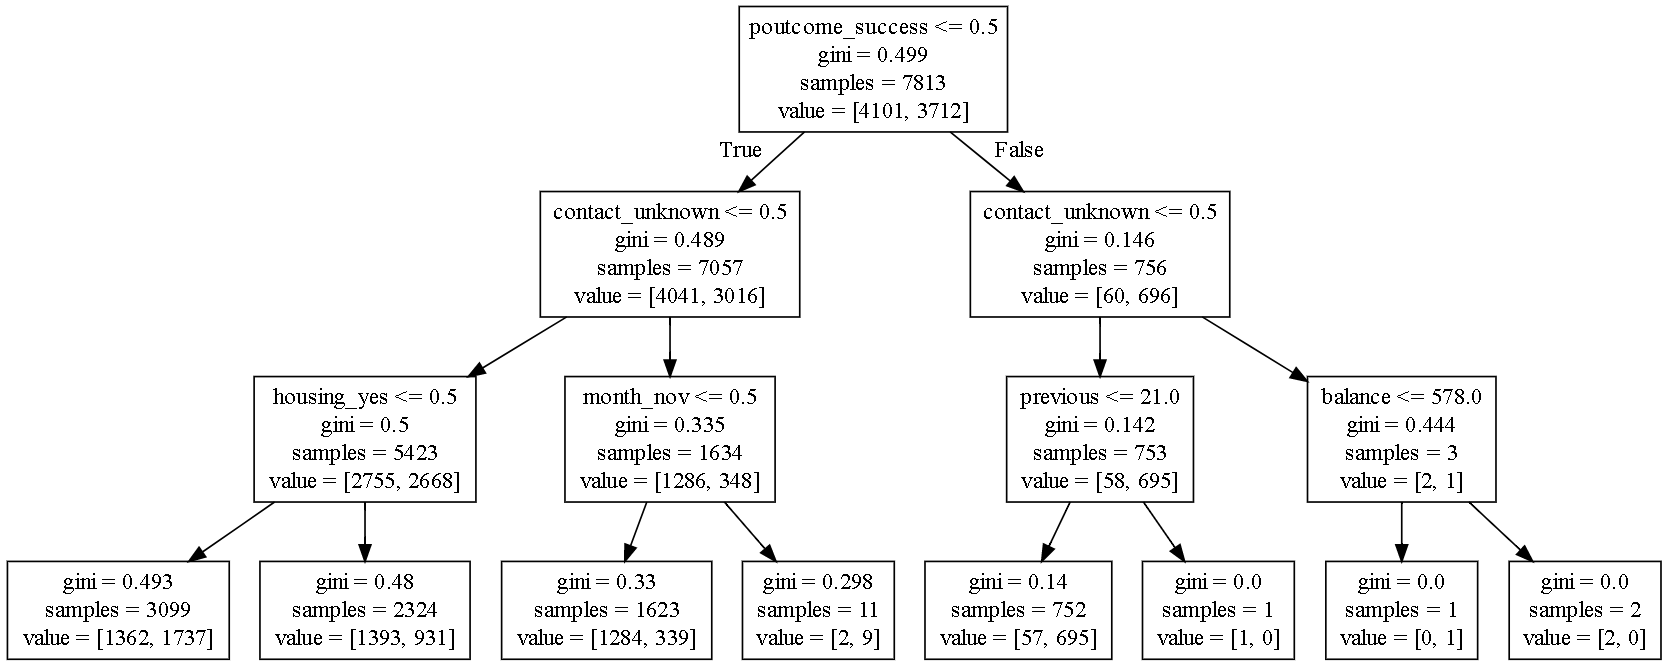

Предскажем значение *accuracy* для валидационного множества

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = tree.predict(X_valid)
accuracy_score(y_valid, y_pred)


 Произведем кросс-валидацию и подборку гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

tree_params = {'max_depth': np.arange(2, 11)            
              }

tree_grid = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy') 
tree_grid.fit(X_train, y_train)

In [ ]:
tree_grid.best_estimator_

In [ ]:
tree_grid.best_score_

Изобразим результаты.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True) # 2 графика рядом с одинаковым масштабом по оси Оу

ax[0].plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score']) # accuracy vs max_depth
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('Mean accuracy on test set')

Выберем и нарисуем лучшее дерево.

In [ ]:
pd.DataFrame(tree_grid.cv_results_).head().T

best_tree = tree_grid.best_estimator_
y_pred = best_tree.predict(X_valid)
accuracy_score(y_valid, y_pred)


In [ ]:
export_graphviz(best_tree, out_file='best_tree.dot')
print(open('best_tree.dot').read())

Рисунок дерева очень громоздкий. Поэтому для того, чтобы его увидеть, необходимо перейти по ссылке:https://dochub.com/dukov/Zxz7E3jVBgOgL4zwlWd2G8/%D0%BB%D1%83%D1%87%D1%88%D0%B5%D0%B5-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE-pdf

# 2. Настройка гиперпараметров дерева

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)

tree.fit(X_train, y_train)


In [ ]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

In [ ]:
tree_params = {'max_depth': range(1,10),
               'max_features': range(1,10)}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

In [ ]:
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
        iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(1, 10), 'max_features': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [ ]:
tree_grid.best_params_

In [ ]:
tree_grid.best_score_

# 3.Построение случайного леса

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(['age','deposit_yes','duration'], axis=1)
y = df['deposit_yes']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, random_state=2019)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=2019, max_depth=6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)

accuracy_score(y_valid, y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

tree_params = {'max_depth': np.arange(2, 11)            
              }

tree_grid = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy') 
tree_grid.fit(X_train, y_train)

In [ ]:
tree_grid.best_estimator_

In [ ]:
tree_grid.best_score_

Оценим важность признаков.

In [ ]:
import matplotlib.pyplot as plt

features = {'f'+str(i+1):name for (i, name) in zip(range(len(df.columns)), df.columns)}
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

print("Feature ranking:")

for f in range(num_to_plot):
    print(f+1, features["f"+str(feature_indices[f])], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);


Наиболее важным признаком является образование клиента. Также важны данные о наличии кредита.  

# 4. Сравнение метода ближайших соседей и случайного леса

Загрузим необходимую базу данных

In [ ]:
print(os.listdir("../input"))
sns.set(rc={'figure.figsize':(10, 8)});
df = pd.read_csv('../input/bank-marketing-dataset/bank.csv')
df.head()

Преобразуем все категориальные признаки в бинарные.

In [ ]:
df = pd.get_dummies(df, columns=['month','default','housing','loan','contact'], drop_first=True)
df = pd.get_dummies(df, columns=['job','marital','education','poutcome','deposit'], drop_first=True)
df.head()

Применим задачу распознавания рукописных цифр, в которой картинки представляются матрицей  8×8  (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64 и получается признаковое описание объекта.

In [ ]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

Разделим выборку на валидационную и обучающую.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2019)

Построим модели случайного леса и  k  ближайших соседей с какими-нибудь параметрами.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

tree = DecisionTreeClassifier(max_depth=15, random_state=2019)
tree_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('tree', DecisionTreeClassifier(max_depth=15, 
                                                      random_state=2019))]) 

tree.fit(X_train, y_train)
tree_pipe.fit(X_train, y_train)

Оценим правильность предсказаний обеих моделей.

In [ ]:
tree_pred = tree.predict(X_valid)
print(accuracy_score(tree_pred, y_valid))

In [ ]:
tree_pipe_pred = tree_pipe.predict(X_valid)
print(accuracy_score(tree_pipe_pred, y_valid))

Правильность предсказания моделей практически совпадают.

# Вывод: наилучший предсказательный результат дает построение модели дерева решений с подбором гиперпараметров.
